In [1]:
import torch
import random
import numpy as np
from rarity_score import *
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset
from PIL import Image
import os

seed = 2302
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class WiderFaceDataset(Dataset):
    def __init__(self, image_dir, annotation_file, transform=None):
        self.image_dir = image_dir
        self.transform = transform
        self.annotations = self.load_annotations(annotation_file)
        self.images = [annotation['image'] for annotation in self.annotations]

    def load_annotations(self, annotation_file):
        annotations = []
        with open(annotation_file, 'r') as file:
            lines = file.readlines()
            i = 0
            while i < len(lines):
                # read the image filename
                image_path = lines[i].strip()
                i += 1

                # the number of faces
                num_faces = int(lines[i].strip())
                i += 1  # Move to the first bounding box line or skip if num_faces is 0

                # if no faces, skip this image
                if num_faces == 0:
                    i += 1
                    continue

                boxes = []
                for _ in range(num_faces):
                    box_info = lines[i].strip().split()
                    # Extract the first four values (x, y, width, height)
                    x, y, w, h = [int(box_info[k]) for k in range(4)]
                    boxes.append([x, y, x + w, y + h])
                    i += 1

                annotations.append({'image': image_path, 'boxes': boxes})

        return annotations



    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        img_path = os.path.join(self.image_dir, self.annotations[index]['image'])
        img = Image.open(img_path)

        original_size = img.size

        # corresponding bounding boxes
        bboxes = self.annotations[index]['boxes']

        # apply image transformations()
        if self.transform:
            img = self.transform(img)

        # scale factors
        scale_x = 299 / original_size[0]
        scale_y = 299 / original_size[1]

        # scale the bounding boxes
        scaled_bboxes = []
        for box in bboxes:
            x1, y1, x2, y2 = box
            scaled_bboxes.append([x1 * scale_x, y1 * scale_y, x2 * scale_x, y2 * scale_y])

        # convert scaled bounding boxes(annotations) to a tensor
        scaled_bboxes = torch.tensor(scaled_bboxes, dtype=torch.float32)

        return img, scaled_bboxes

transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# load datasets
train_wider_dataset = WiderFaceDataset(image_dir='./widerface_data/widerface/WIDER_train/images/', 
                                 annotation_file='./widerface_data/widerface/wider_face_split/wider_face_train_bbx_gt.txt', 
                                 transform=transform_inception)
test_wider_dataset = WiderFaceDataset(image_dir='./widerface_data/widerface/WIDER_val/images/', 
                                 annotation_file='./widerface_data/widerface/wider_face_split/wider_face_val_bbx_gt.txt', 
                                 transform=transform_inception)

# train_wider_dataset = datasets.WIDERFace("./widerface_data", split ="train", download=True, transform = transform_inception)
# test_wider_dataset = datasets.WIDERFace("./widerface_data", split ="test", download=True, transform = transform_inception)

# load feature extractor
inception = models.inception_v3(pretrained=True).to(device)


def collate_fn(batch):
    images = [item[0] for item in batch]
    annotations = [item[1] for item in batch]  # handle varying-size annotations

    # stack the images into a single tensor
    images = torch.stack(images, dim=0)

    return images, annotations


train_wider_loader = DataLoader(train_wider_dataset, batch_size=64, collate_fn=collate_fn)
test_wider_loader = DataLoader(test_wider_dataset, batch_size=64, collate_fn=collate_fn)

def extract_features(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            images = batch[0].to(device)
            output = model(images)
            features.append(output.cpu())
    return torch.cat(features, dim=0)

real_wider_features = extract_features(inception, train_wider_loader)
fake_wider_features = extract_features(inception, test_wider_loader)

real_wider_features = real_wider_features.numpy()
fake_wider_features = fake_wider_features.numpy()

manifold = MANIFOLD(real_features=real_wider_features, fake_features=fake_wider_features)
score, score_index = manifold.rarity(k=3)
print(score[score_index])
np.savetxt('./result/inception_widerface.txt', score)

C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [01:02<00:00,  1.23s/it]


Pre-processing pairwise diatances ...
Initialization is DONE !
[52.22301369 50.24004482 50.17362354 ...  9.92718466  9.40926813
  8.67602802]


In [1]:
import torch
import random
import numpy as np
from rarity_score import *
from torchvision import datasets, transforms, models
from tqdm import tqdm
from torch.utils.data import DataLoader,Dataset, random_split
from PIL import Image
import os

seed = 2302
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


transform_inception = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dataset = datasets.CelebA(root="./celeba_data", split="all", download=False, transform=transform_inception)

inception = models.inception_v3(pretrained=True).to(device)

# split into 'real' and 'fake' portions
fake_percentage = 0.3
fake_size = int(len(dataset) * fake_percentage)
real_size = len(dataset) - fake_size
real_dataset, fake_dataset = random_split(dataset, [real_size, fake_size])

real_loader = DataLoader(real_dataset, batch_size=256)
fake_loader = DataLoader(fake_dataset, batch_size=256)

def extract_features(model, data_loader):
    model.eval()
    features = []
    with torch.no_grad():
        for batch in tqdm(data_loader):
            images = batch[0].to(device)
            output = model(images)
            features.append(output.cpu())
    return torch.cat(features, dim=0)

real_features = extract_features(inception, real_loader)
fake_features = extract_features(inception, fake_loader)

real_features = real_features.numpy()
fake_features = fake_features.numpy()

nearest_k = 3
manifold = MANIFOLD(real_features=real_features, fake_features=fake_features)
score, score_index = manifold.rarity(k=nearest_k)
print(score[score_index])

np.savetxt("./result/inception_celeba.txt", score)

import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def tensor_to_pil(tensor):
    # undo the normalization
    unnormalize = T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1/0.229, 1/0.224, 1/0.225])
    tensor = unnormalize(tensor)
    # convert to PIL Image
    return T.ToPILImage()(tensor)

non_zero_scores = score[score != 0]
sorted_scores = np.sort(non_zero_scores)

# indcies for lowest and highest scores
lowest_indices = score_index[-3:]
highest_indices = score_index[:3]

# idx for median score
median_score = np.median(sorted_scores)
median_index = np.where(score == median_score)[0][0]

zero_indices = score[score == 0]

def save_image(dataset, index, filename):
    image_tensor, _ = dataset[index]
    image = tensor_to_pil(image_tensor)
    image.save(f'./result/inception_celeba/{filename}')

for i, index in enumerate(lowest_indices):
    save_image(dataset, index, f'lowest_{i+1}.png')

for i, index in enumerate(highest_indices):
    save_image(dataset, index, f'highest_{i+1}.png')

for i, index in enumerate(zero_indices[:3] if len(zero_indices)>=3 else zero_indices):
    save_image(dataset, index, f'zero_{i+1}.png')

save_image(dataset, median_index, 'median.png')


C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\johnw\anaconda3\envs\deeplearn\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  5%|███▊                                                                             | 26/554 [00:31<10:44,  1.22s/it]


KeyboardInterrupt: 

In [7]:
all_celeba_dataset = datasets.CelebA(root="./celeba_data/", split="all", download=False, transform=transform_inception)

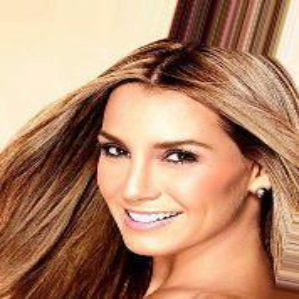

In [12]:
import torchvision.transforms as T
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

# Function to convert a tensor to a PIL Image
def tensor_to_pil(tensor):
    # Undo the normalization
    unnormalize = T.Normalize(mean=[-0.485 / 0.229, -0.456 / 0.224, -0.406 / 0.225], std=[1/0.229, 1/0.224, 1/0.225])
    tensor = unnormalize(tensor)
    # Convert to PIL Image
    return T.ToPILImage()(tensor)
# Extract the image tensor part of the first data point
image_tensor, _ = all_celeba_dataset[0]

# Convert the tensor to a PIL Image
image = tensor_to_pil(image_tensor)

image